An energy minimization procedure consists in adjusting the coordinates of the atoms that are too close from one another until one of the stopping criteria is reached. By default, LAMMPS uses the conjugate gradient (CG) algorithm. Here there are four stopping criteria:

    The change in energy between two iterations is less than 1.0e-4,

    The maximum force between two atoms in the system is lower than 1.0e-6,

    The maximum number of iterations is 1000,

    The maximum number of times the force and the energy have been evaluated is 10000.
    
NVT 
we preform a temperature adjustment using a canonical sampling thermostat.  the thermostat is similar to the empirical Berendsen thermostat in temp/berendsen, but chooses the actual scaling factor from a suitably chosen (gaussian) distribution rather than having it determined from the time constant directly.

Unlike the fix nvt command which performs Nose/Hoover thermostatting AND time integration, these fixes do NOT perform time integration. They only modify velocities to effect thermostatting. Thus you must use a separate time integration fix, like fix nve to actually update the positions of atoms using the modified velocities.


In [74]:
# import plumed
import matplotlib.pyplot as plt
import os
# import MDAnalysis

In [75]:
# set working directory for all future cells
os.chdir("/home/lammps/plumed/PRL-2017-PairEntropy/Project/Proj23")
# and check with bash command pwd - note the exclamation mark at the beginning
!pwd
# or in python
os.getcwd()

/home/lammps/plumed/PRL-2017-PairEntropy/Project/Proj23


'/home/lammps/plumed/PRL-2017-PairEntropy/Project/Proj23'

In [140]:
%%bash
cat > "in.partitions" << EOF
    variable p_id world   0 # 1 2 3 4 5
EOF

cat > "in.temp" << EOF
    variable temperature equal \${tmp}
    variable tempDamp equal 0.1 # approx 0.1 ps
EOF

cat > "in.pressure" << EOF
    variable pressure equal 1.
    variable pressureDamp equal 10.0
EOF

cat > "in.seed" << EOF
    variable seed world 74581 # 93734 12832 21934 57383 49172
EOF

cat > "in.box" << EOF
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 \${side} 0 \${side} 0 \${side}
    create_box      1 box
    create_atoms    1 random \${numAtoms} \${seed} box
    mass            1 \${mass}
    change_box      all triclinic
EOF

cat > "in.na" << EOF
    ### Argon Potential Parameters ###
    pair_style  eam/fs
    pair_coeff  * * Na_MendelevM_2014.eam.fs Na
EOF


cat > "in.setup" << EOF
    variable        out_freq equal 500
    variable        out_freq2 equal 25000
    neigh_modify    delay 10 every 1
    include         in.na
    timestep        0.002 # According to Frenkel and Smit is 0.001
    thermo          \${out_freq}
    thermo_style    custom step pe ke press lx ly lz xy xz yz pxx pyy pzz pxy pxz pyz
    restart         \${out_freq2} restart/restart.\${temperature} #restart2.\${p_id}
EOF

cat > "in.dump" << EOF
    dump         myDump all atom \${out_freq2} dump.\${p_id}
    dump_modify  myDump append yes
EOF

In [141]:
%%bash
# create PLUMED input file
cat > "start.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
include in.box
include in.setup

minimize 1.0e-2 1.0e-3 100 1000
reset_timestep 0

# NVT
variable kenergy equal ke
variable penergy equal pe
variable pressure equal press
variable tempera equal temp

fix myat1 all ave/time 10 1 10 v_kenergy v_penergy v_pressure v_tempera file data/energy\${temperature}.dat


fix             1 all nve
fix             2 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}

velocity        all create \${temperature} \${seed} dist gaussian
run             25000

unfix           1
unfix           2

neigh_modify every 1 delay 5 check yes

EOF


In [ ]:
import subprocess

for temp in range(300,401,25):
    cmd = f"lmp -v tmp {temp} -in start.lmp"
    results = subprocess.run(cmd, shell=True, universal_newlines=True, check=True)

LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal ${tmp}
    variable temperature equal 300
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
include in.box
    variable        side equal 22.0
    variable        numAtoms equal 250
    variable        mass equal 22.98977
    region          box block 0 ${side} 0 ${side} 0 ${side}
    region          box block 0 22 0 ${side} 0 ${side}
    region          box block 0 22 0 22 0 ${side}
    region          box block 0 22 0 22 0 22
    create_box      1 box
Created orthogonal box = (0

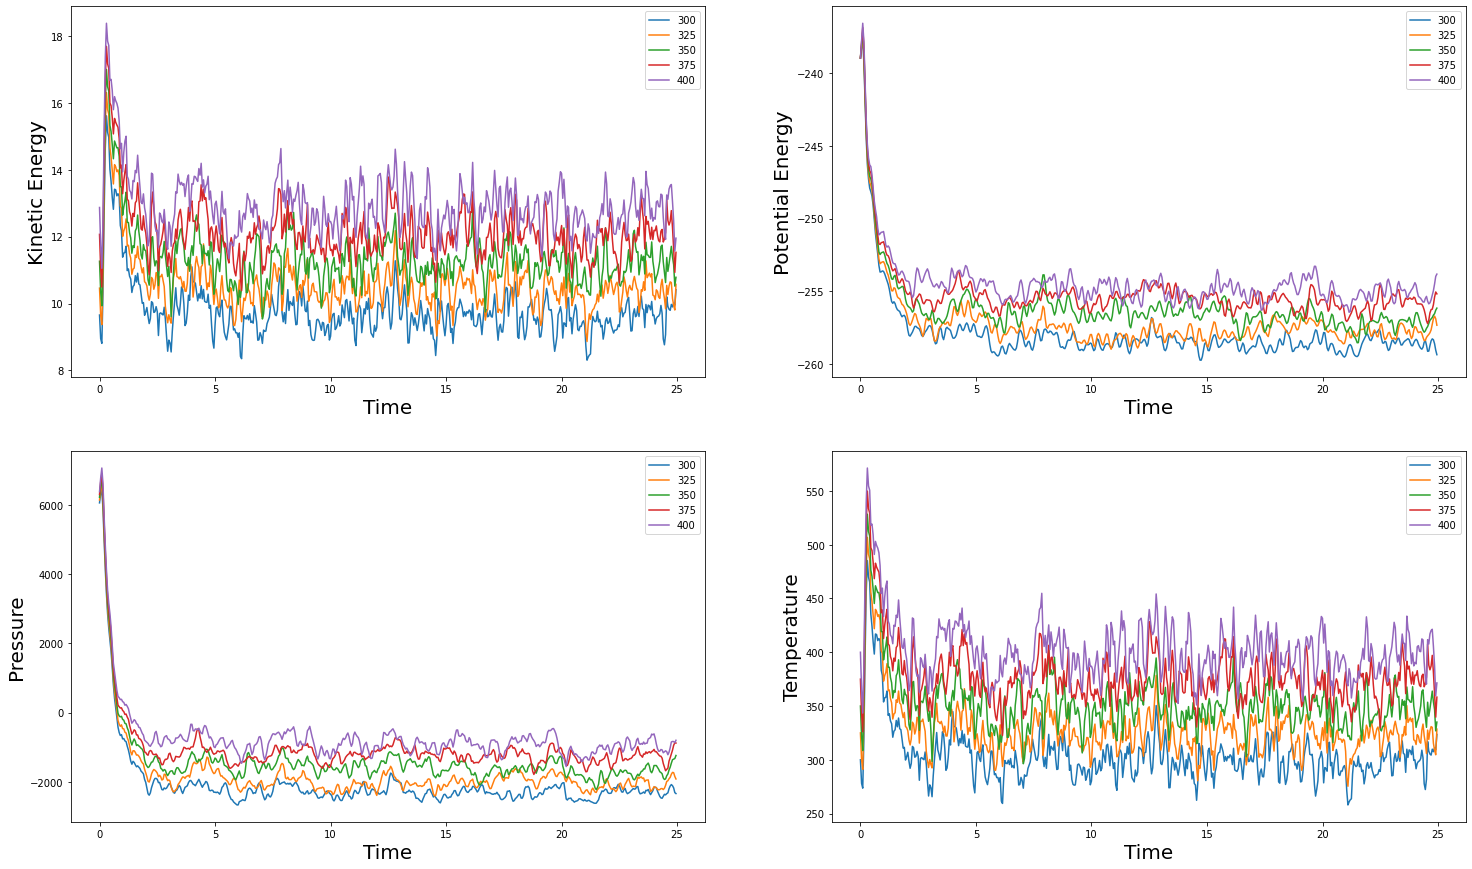

In [135]:
import copy
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['Kinetic Energy', 'Potential Energy', 'Pressure', 'Temperature']
temperatures = range(300,401,25)
fontsize = 20
font = {'family': 'sans', 'color':  'black', 'weight': 'normal', 'size': fontsize}

energy = {}
for tmp in temperatures:
    energy[tmp] = np.loadtxt('data/energy{}.dat'.format(tmp)) # ke, pe, press, temp

fig = plt.figure(figsize=(25, 15))
for n,label in enumerate(labels):
    ax = fig.add_subplot(2,2,n+1)
    for tmp in temperatures:
        plt.plot((energy[tmp].T[0][:500]-energy[tmp].T[0][0])*0.005, energy[tmp].T[n+1][:500], label=tmp)
    ax.set_xlabel('Time', fontdict=font)
    ax.set_ylabel(label, fontdict=font)
    ax.legend()

plt.show()



In [8]:
%%bash
# create PLUMED input file
cat > "start.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
read_restart restart.\${p_id}
include in.setup

# NVT

# variable kinetic_energy equal ke
# variable potential_energy equal pe
# # variable pressure equal press
# fix myat2 all ave/time 10 1 10 v_kinetic_energy v_potential_energy file energy2.dat

fix             1 all nph iso \${pressure} \${pressure} \${pressureDamp}
fix             2 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}

velocity        all create \${temperature} \${seed} dist gaussian
run             25000

unfix           1
unfix           2

EOF

In [9]:
%%bash
lmp -in start.lmp

LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal 350.
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
read_restart restart.${p_id}
read_restart restart.0
Reading restart file ...
  restart file = 30 Jul 2021, LAMMPS = 30 Jul 2021
  restoring atom style full from restart
  triclinic box = (0.0000000 0.0000000 0.0000000) to (22.000000 22.000000 22.000000) with tilt (0.0000000 0.0000000 0.0000000)
  1 by 1 by 1 MPI processor grid
  pair style eam/fs stores no restart info
  250 atoms
Finding 1-2 1-3 1-4 neighbors ...
  special bo

   36000    343.82317   -257.48273    13.000879    21.797061    21.797061    21.797061            0            0            0    43.439335    393.21212   -397.64882    830.78175   -94.618683     950.4582 
   36500    353.87472   -259.64075    385.76993    21.681254    21.681254    21.681254            0            0            0     625.1079    459.42271    72.779164    21.980191    64.948937    341.49032 
   37000     382.6283   -258.46955    881.28656    21.657925    21.657925    21.657925            0            0            0    136.98335    1759.3713    747.50498    316.33659   -588.48949   -215.28531 
   37500     342.7107    -256.9718    298.13928    21.767631    21.767631    21.767631            0            0            0    170.01657    836.32495   -111.92366    79.862243     194.8812   -314.69328 
   38000    348.80845   -257.05038   -780.79714    21.879765    21.879765    21.879765            0            0            0   -438.54635   -949.36419   -954.48087   -225.30079   

In [10]:
%%bash
# create PLUMED input file
cat > "start.lmp" << EOF
echo both

include in.partitions
log log.lammps.\${p_id} append

include in.temp
include in.pressure
include in.seed
units metal
atom_style full
box tilt large
read_restart restart.\${p_id}
include in.setup

# NPT

timer           timeout 23:50:00 every 5000
reset_timestep  0
include         in.dump

fix             1 all plumed plumedfile plumed.start.dat outfile plumed.out
fix             2 all nph &
                x \${pressure} \${pressure} \${pressureDamp} &
                y \${pressure} \${pressure} \${pressureDamp} &
                z \${pressure} \${pressure} \${pressureDamp} &
                xy 0.0 0.0 \${pressureDamp} &
                yz 0.0 0.0 \${pressureDamp} &
                xz 0.0 0.0 \${pressureDamp} &
                couple xyz
fix             3 all temp/csvr \${temperature} \${temperature} \${tempDamp} \${seed}
fix             4 all momentum 10000 linear 1 1 1 angular

run             500000 # 1 ns

EOF

In [11]:
%%bash
lmp -in start.lmp

LAMMPS (30 Jul 2021)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task

include in.partitions
    variable p_id world   0 # 1 2 3 4 5
log log.lammps.${p_id} append
log log.lammps.0 append

include in.temp
    variable temperature equal 350.
    variable tempDamp equal 0.1 # approx 0.1 ps
include in.pressure
    variable pressure equal 1.
    variable pressureDamp equal 10.0
include in.seed
    variable seed world 74581 # 93734 12832 21934 57383 49172
units metal
atom_style full
box tilt large
read_restart restart.${p_id}
read_restart restart.0
Reading restart file ...
  restart file = 30 Jul 2021, LAMMPS = 30 Jul 2021
  restoring atom style full from restart
  triclinic box = (0.14275131 0.14275131 0.14275131) to (21.857249 21.857249 21.857249) with tilt (0.0000000 0.0000000 0.0000000)
  1 by 1 by 1 MPI processor grid
  pair style eam/fs stores no restart info
  250 atoms
Finding 1-2 1-3 1-4 neighbors ...
  special

CalledProcessError: Command 'b'lmp -in start.lmp\n'' returned non-zero exit status 1.